## Scenario Analysis for a 100% renewable electricity system in Chile

### Shapes

In [1]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Projection to use for all calculations
# ESRI:102033: South_America_Albers_Equal_Area_Conic
c = "ESRI:102033"

#### Splitting Chile into regions

In [3]:
chile_regions = gpd.read_file("./data/chile_regions.gpkg", layer="gadm_410-levels-ADM_1-CHL").to_crs(c)
chile_regions = chile_regions.drop(["GID_0", "GID_1", "COUNTRY"],axis=1)
chile_regions.to_file("./data/chile_regions.geojson", index=False)
chile_regions

,NAME_1,geometry
0,Antofagasta,"MULTIPOLYGON (((-1016371.591 675559.51, -10163..."
1,Araucanía,"MULTIPOLYGON (((-971963.615 -837915.515, -9718..."
2,Arica y Parinacota,"MULTIPOLYGON (((-938407.45 1605778.685, -93839..."
3,Atacama,"MULTIPOLYGON (((-1047038.508 369010.778, -1047..."
4,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-1213108.635 -1932511.434, -12..."
5,Bío-Bío,"MULTIPOLYGON (((-1191950.933 -780368.49, -1191..."
6,Coquimbo,"MULTIPOLYGON (((-957737.833 46693.277, -957762..."
7,Libertador General Bernardo O'Hi,"MULTIPOLYGON (((-1017301.128 -370804.166, -101..."
8,Los Lagos,"MULTIPOLYGON (((-1202905.714 -1365539.851, -12..."
9,Los Ríos,"MULTIPOLYGON (((-996499.677 -1017222.28, -9963..."


#### Aggregate land regions and add EEZ regions

In [4]:
def aggregate_regions(geodataframe, num_regions):
    # use clustering algorithms K-means to create clusters
    ## extract coordinates for KMeans clustering
    coords = np.array(list(geodataframe.geometry.centroid.apply(lambda point: [point.x, point.y])))
    ## create clusters of regions
    # Create clusters of regions using Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=num_regions)
    geodataframe["cluster"] = agglomerative.fit_predict(coords)

    # aggregate regions by clusters
    geodataframe = geodataframe.dissolve(by="cluster")
    #geodataframe.NAME_1 = ["CHL1", "CHL2", "CHL3", "CHL4", "CHL5"]
    geodataframe = geodataframe.loc[:, ["geometry"]]
    
    return geodataframe

In [5]:
aggregated_regions = aggregate_regions(chile_regions, 5)
aggregated_regions

,geometry
cluster,
0,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12..."
1,"MULTIPOLYGON (((-1016371.146 675402.505, -1016..."
2,"MULTIPOLYGON (((-4569434.628 -194281.234, -456..."
3,"MULTIPOLYGON (((-1062555.119 240263.988, -1062..."
4,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12..."


In [6]:
def get_country_economic_zone(EEZ, country):
    """extract the Exclusive Economic Zone (EEZ) for a chosen country
    INPUT:  EEZ                 - GeoDataFrame of EEZ
            country             - Name of the country in string
    OUTPUT: gpd.GeoDataFrame    - GeoDataFrame of the country's EEZ
    """
    return EEZ.query(f"SOVEREIGN1 == '{country}'")

In [7]:
# load Exclusive economic zones
EEZ_boundaries = gpd.read_file("./data/EEZ_boundaries.gpkg")
EEZ = gpd.read_file("./data/EEZ.gpkg")

In [8]:
# Exclusive economic zone of Chile
## extract Chile's EEZ
chile_EEZ = get_country_economic_zone(EEZ, "Chile").to_crs(c)
chile_EEZ = chile_EEZ.rename(columns = {"GEONAME":"NAME_1"}).loc[:, ["NAME_1", "geometry"]].set_index("NAME_1")

In [9]:
## combine Chile aggregated regions and EEZ
aggregated_regions = pd.concat([aggregated_regions["geometry"], chile_EEZ])[0:6]
aggregated_regions["NAME_1"] = ["Southern Chile", "Antofagasta", "Central Chile", "Atacama", "Central Southern Chile", "Chilean Exclusive Economic Zone"]
aggregated_regions.to_file("./data/aggregated_regions.gpkg", index=False)
aggregated_regions = aggregated_regions.rename({"NAME_1": "aggRegion"}, axis=1).set_index("aggRegion")
aggregated_regions

,geometry
aggRegion,
Southern Chile,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12..."
Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016..."
Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456..."
Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062..."
Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12..."
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807..."


#### Determine the centroids per region

In [10]:
aggregated_centroids = aggregated_regions.copy()
aggregated_centroids["geometry"] = aggregated_centroids["geometry"].centroid
aggregated_centroids

,geometry
aggRegion,
Southern Chile,POINT (-971663.072 -2003105.132)
Antofagasta,POINT (-901039.878 1099511.252)
Central Chile,POINT (-1011852.22 -417673.507)
Atacama,POINT (-951210.569 373578.008)
Central Southern Chile,POINT (-1058735.91 -1021567.479)
Chilean Exclusive Economic Zone,POINT (-1336850.992 -849742.084)


### Renewable Potentials

#### Land Eligibility Analysis

In [11]:
country_shapes = "./data/country_shapes.geojson"
roads = "./data/roads.gpkg"
airports = "./data/airports.gpkg"
natural_protection_areas = "./data/natural_protection_areas.tif"
elevation = "./data/elevation.nc"
land_cover = "./data/land_cover.tif"

In [12]:
def plot_area(masked, transform, shape, x, y, cmap, subplots=0):
    fig, ax = plt.subplots(figsize=(x,y))
    ax = show(masked, transform=transform, cmap=cmap, vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [13]:
def area_percent(masked, excluder, shape):
    return masked.sum() * (excluder.res**2) / shape.geometry.area * 100

In [14]:
def area_km2(masked, excluder, shape):
    return masked.sum() * (excluder.res**2) / 1000000

In [15]:
# Shape of Chile
CHL = gpd.read_file(country_shapes).set_index('name').query("name == 'CL'").to_crs(c).geometry

# Shapes for onshore, offshore and solar
shape_onshore = CHL.geometry 

shape_solar = CHL.geometry

shape_offshore = chile_EEZ.geometry # within EEZ


#### Onshore

In [16]:
excluder_onshore = ExclusionContainer(crs=c)
# 300m distance to major roads
excluder_onshore.add_geometry(roads, buffer=300)
# 10km distance to airports
excluder_onshore.add_geometry(airports, buffer=10000)
# No natural protection areas
excluder_onshore.add_raster(natural_protection_areas, crs=4326)
# Maximum elevation of 2000m
excluder_onshore.add_raster(elevation, codes=lambda x: x>2000, crs=4326)

# 1000m distance to built up areas (i.e. urban land cover class code 50)
excluder_onshore.add_raster(land_cover, codes=[50], buffer=1000, crs=4326)

# Analysis on suitable land cover classes (based on Copernicus document)
## The land cover classes suitable for onshore wind would generally exclude 
## urban, forested (closed forest), agricultural areas with dense canopy, and wetlands, 
## favoring open, non-protected areas.
## Therefore, exclude these code classes [111, 113, 112, 114, 115, 116, 20, 90, 50, 70, 80, 200]
excluder_onshore.add_raster(land_cover, codes=[111, 113, 112, 114, 115, 116, 20, 90, 50, 70, 80, 200], buffer=100, crs=32719) 


In [17]:
# calculate available area for onshore wind
masked_onshore, transform_onshore = shape_availability(shape_onshore, excluder_onshore)

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


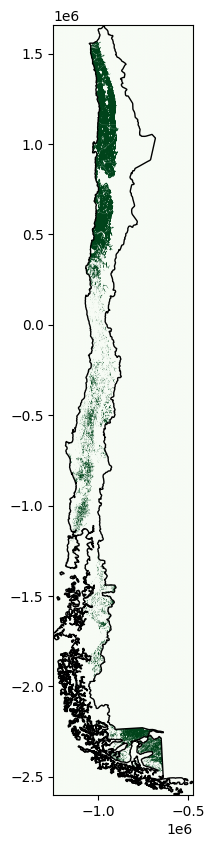

In [18]:
# plot available area for onshore wind
plot_area(masked_onshore, transform_onshore, shape_onshore, 10,10, "Greens")

In [19]:
# calculate available area for onshore wind in single regions
masked_onshore_regions = []
transform_onshore_regions = []
for i in range(0, 5):
    masked_onshore, transform_onshore = shape_availability(gpd.GeoSeries(aggregated_regions.iloc[i]), excluder_onshore)
    masked_onshore_regions.append(masked_onshore)
    transform_onshore_regions.append(transform_onshore)

In [20]:
area_onshore_regions_percent = []
for i in range(0, len(masked_onshore_regions)):
    area_onshore_regions_percent.append(area_percent(masked_onshore_regions[i], excluder_onshore, aggregated_regions.iloc[i]))
area_onshore_regions = []
for i in range(0, len(masked_onshore_regions)):
    area_onshore_regions.append(area_km2(masked_onshore_regions[i], excluder_onshore, aggregated_regions.iloc[i]))

In [22]:
area_regions = pd.DataFrame(aggregated_regions.index).copy()
area_regions["area_onshore [km2]"] = area_onshore_regions+[0]
area_regions["area_onshore [%]"] = area_onshore_regions_percent+[0]
area_regions = area_regions.set_index("aggRegion")
area_regions

,area_onshore [km2],area_onshore [%]
aggRegion,,
Southern Chile,36251.04,15.124582
Antofagasta,68702.16,37.552794
Central Chile,13697.89,11.873802
Atacama,31913.50,27.446658
Central Southern Chile,13252.83,13.478618
Chilean Exclusive Economic Zone,0.00,0.000000


In [23]:
# Power capacity of onshore wind based on deployment density of 3 MW/km^2
aggregated_renewables = aggregated_regions.copy()
aggregated_renewables['onshore [MW]'] = area_regions["area_onshore [km2]"] * 3   # MW
aggregated_renewables

,geometry,onshore [MW]
aggRegion,,
Southern Chile,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12...",108753.12
Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",206106.48
Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",41093.67
Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",95740.50
Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",39758.49
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",0.00


#### Offshore

In [24]:
excluder_offshore = ExclusionContainer(crs=c)

# No natural protection areas
excluder_offshore.add_raster(natural_protection_areas, crs=4326)

# 10 km minimum distance to shore
excluder_offshore.add_geometry(CHL, buffer=10000)

# Up to water depth of 50m
excluder_offshore.add_raster(elevation, codes=lambda x: x<-50, crs=4326)

In [25]:
masked_offshore, transform_offshore = shape_availability(gpd.GeoSeries(shape_offshore, crs=c), excluder_offshore)

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


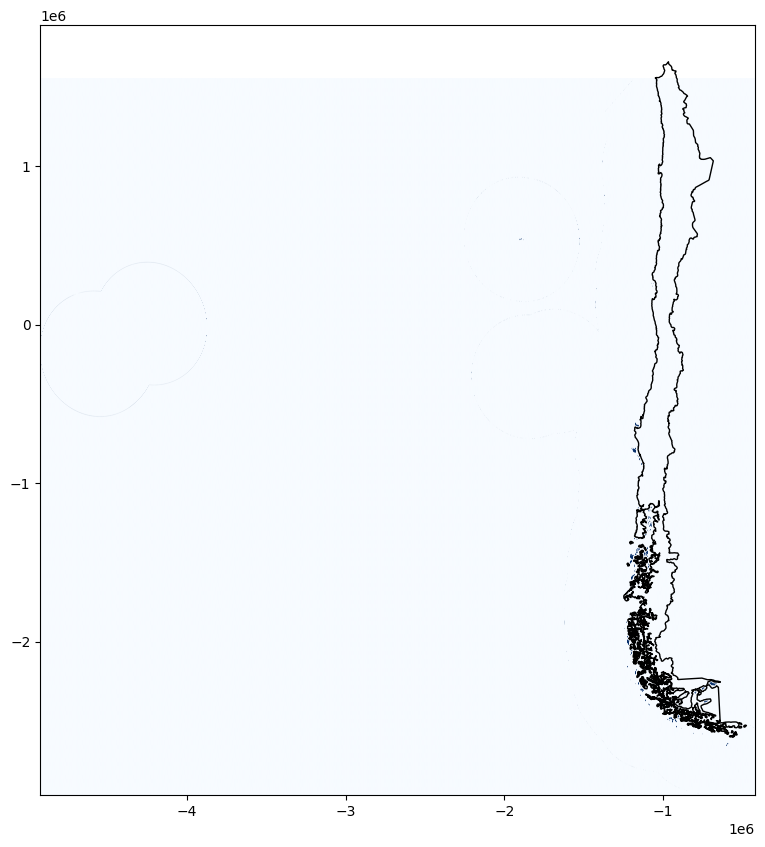

In [26]:
plot_area(masked_offshore, transform_offshore, CHL, 20, 10, 'Blues')

In [27]:
area_offshore_chile = area_km2(masked_offshore, excluder_offshore, shape_offshore)

In [28]:
# Power capacity of offshore wind based on deployment density of 3 MW/km^2
aggregated_renewables['offshore [MW]']=  [0, 0, 0, 0, 0] + [area_offshore_chile * 3]  # MW
aggregated_renewables

,geometry,onshore [MW],offshore [MW]
aggRegion,,,
Southern Chile,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12...",108753.12,0.00
Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",206106.48,0.00
Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",41093.67,0.00
Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",95740.50,0.00
Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",39758.49,0.00
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",0.00,25489.89


In [29]:
percentage_offshore_chile = area_offshore_chile / shape_offshore.geometry.area.values.sum() * 1000000 * 100
print("Eligible offshore wind area in Chile: "+str(area_offshore_chile)+" km2 or "+str(percentage_offshore_chile)+"% of total EEZ area excluding islands")

Eligible offshore wind area in Chile: 8496.63 km2 or 0.23158127160414818% of total EEZ area excluding islands


#### Solar

In [30]:
excluder_solar = ExclusionContainer(crs=c)

# Natural protection areas
excluder_solar.add_raster(natural_protection_areas, crs=4326)
# No major roads
excluder_solar.add_geometry(roads, buffer=20)
# No airports
excluder_solar.add_geometry(airports, buffer=1000)
# Slope of ground  
#excluder_solar.add_raster(slope_deg, crs=4326)
# Maximum elevation of 2000m
excluder_solar.add_raster(elevation, codes=lambda x: x>2000, crs=4326)

# Analysis on suitable land cover classes
## The land cover classes suitable for solar (rooftop and utility) would generally exclude 
## forested, agricultural areas with dense canopy, and wetlands, 
## favoring open, non-protected areas.
## Therefore, exclude these code classes [111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 90, 70, 80, 200]

excluder_solar.add_raster(land_cover, codes=[111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 90, 70, 80, 200], buffer=100, crs=4326)

In [31]:
masked_solar, transform_solar = shape_availability(gpd.GeoSeries(CHL, crs=c), excluder_solar)

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/atlite/gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


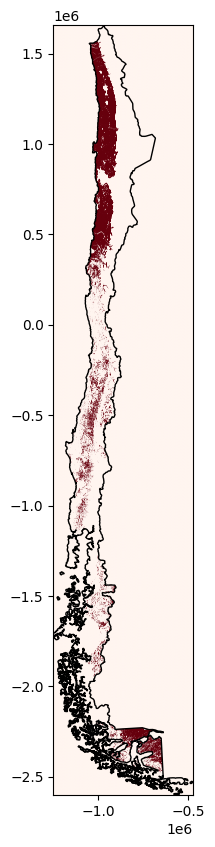

In [32]:
plot_area(masked_solar, transform_solar, CHL, 20, 10, 'Reds')

In [33]:
# calculate available area for onshore wind in single regions
masked_solar_regions = []
transform_solar_regions = []
for i in range(0, 5):
    masked_solar, transform_solar = shape_availability(gpd.GeoSeries(aggregated_regions.iloc[i]), excluder_solar)
    masked_solar_regions.append(masked_solar)
    transform_solar_regions.append(transform_solar)

In [34]:
area_solar_regions = []
for i in range(0, len(masked_solar_regions)):
    area_solar_regions.append(area_km2(masked_solar_regions[i], excluder_solar, aggregated_regions.iloc[i]))
area_solar_regions_percent = []
for i in range(0, len(masked_solar_regions)):
    area_solar_regions_percent.append(area_percent(masked_solar_regions[i], excluder_solar, aggregated_regions.iloc[i]))

In [36]:
area_regions = pd.DataFrame(aggregated_regions.index).copy()
area_regions["area_solar [km2]"] = area_solar_regions+[0]
area_regions["area_solar [%]"] = area_solar_regions_percent+[0]
area_regions = area_regions.set_index("aggRegion")
area_regions

,area_solar [km2],area_solar [%]
aggRegion,,
Southern Chile,36040.62,15.036791
Antofagasta,70786.64,38.692176
Central Chile,18518.87,16.052794
Atacama,32961.46,28.347938
Central Southern Chile,9437.90,9.598693
Chilean Exclusive Economic Zone,0.00,0.000000


In [37]:
# Power capacity of solar based on deployment density of 3 MW/km^2
aggregated_renewables['solar [MW]'] = area_regions["area_solar [km2]"] * 3 # MW
aggregated_renewables

,geometry,onshore [MW],offshore [MW],solar [MW]
aggRegion,,,,
Southern Chile,"MULTIPOLYGON (((-1214328.023 -1995026.437, -12...",108753.12,0.00,108121.86
Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",206106.48,0.00,212359.92
Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",41093.67,0.00,55556.61
Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",95740.50,0.00,98884.38
Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",39758.49,0.00,28313.70
Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",0.00,25489.89,0.00


### Weather Data

In [38]:
cutout = atlite.Cutout(
	path="./data/cutout-2013-era5-comp.nc",
	module="era5",
	#x = slice(-75, -66),
	#y = slice(-17, -56),
	#time="2013",
)

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/atlite/cutout.py:156: UserWarning: Arguments module are ignored, since cutout is already built.
  warn(


### Onshore wind - Vestast V112 3MW

In [39]:
aggregated_regions.geometry = gpd.GeoSeries(aggregated_regions["geometry"], crs=c)

In [40]:
A = cutout.availabilitymatrix(aggregated_regions.geometry, excluder_onshore)

In [41]:
# For both wind and solar, assume a deployment density of 3 MW/km2
cap_per_sqkm = 3 # MW/km2
area = cutout.grid.to_crs("ESRI:102033").set_index(['y', 'x']).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
onshore_capacity_matrix = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm

In [42]:
wind = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=onshore_capacity_matrix,
    index=aggregated_regions.index,
    per_unit=True,
)
wind = wind.to_pandas()

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/atlite/resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


In [43]:
wind.to_csv("./data/A_Wind.csv", index=False)

### Solar panel - CdTe

In [44]:
A_solar = cutout.availabilitymatrix(aggregated_regions.geometry[:5], excluder_solar)

In [45]:
capacity_matrix_solar = A_solar.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [46]:
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix_solar,
    orientation='latitude_optimal',
    index=aggregated_regions[:5].index,
    per_unit=True,
)
df_pv = pv.to_pandas()

<Axes: xlabel='time'>

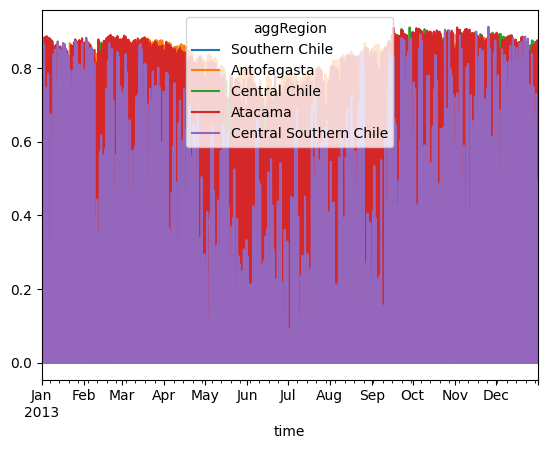

In [47]:
df_pv.plot()

In [48]:
df_pv.to_csv("./data/A_Solar.csv", index=False)

### Offshore wind - NREL ReferenceTurbine 5MW offshore

In [49]:
A_offshore = cutout.availabilitymatrix(aggregated_regions[5:6], excluder_offshore)

In [50]:
# For both wind and solar, assume a deployment density of 3 MW/km2
cap_per_sqkm = 3 # MW/km2
area = cutout.grid.to_crs("ESRI:102033").set_index(['y', 'x']).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
offshore_capacity_matrix = A_offshore.stack(spatial=["y", "x"]) * area * cap_per_sqkm

In [51]:
windoffshore = cutout.wind(
    atlite.windturbines.NREL_ReferenceTurbine_5MW_offshore,
    matrix=offshore_capacity_matrix,
    index=aggregated_regions[5:6].index,
    per_unit=True,
)
df_offshore = windoffshore.to_pandas()

/opt/homebrew/Cellar/jupyterlab/4.4.0_1/libexec/lib/python3.13/site-packages/atlite/resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='time'>

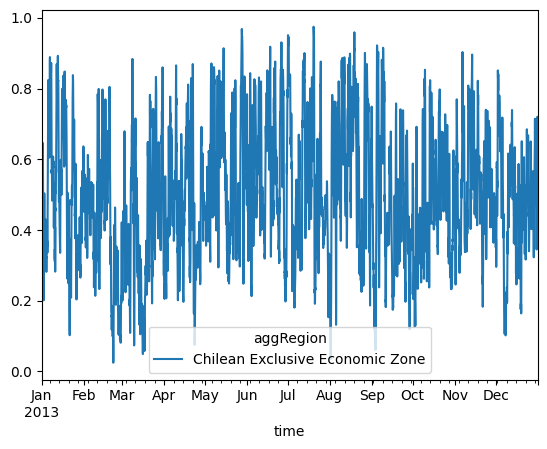

In [52]:
df_offshore.plot()

In [53]:
df_offshore.to_csv("./data/A_Offshore.csv", index=False)